<a href="https://colab.research.google.com/github/nidjosep/Best-README-Template/blob/master/TME_6015_Assignment_2_C_HuggingFace_3741627.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this Colab notebook, we'll use a pre-trained model from HuggingFace for predictions on the *cats_vs_dogs* dataset on HuggingFace. I've chosen the *EfficientNetV2* as the pre-trained model for this exercise.

HuggingFace Model: https://huggingface.co/microsoft/resnet-18

HuggingFace Dataset: https://huggingface.co/datasets/cats_vs_dogs

# 1. Setting up environment

In [ ]:
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.9 MB/s eta 0:00:00


In this exercise, we utilize the Hugging Face's transformers and datasets libraries. The transformers library can be used to load models, while the datasets library can be used to load the required HuggingFace dataset. Unlike our previous implementations where we leveraged TensorFlow, here, we use the Hugging Face ecosystem.

# 2. Loading the pre-trained *ResNet18* model

In [ ]:
from transformers import ConvNextImageProcessor, ResNetForImageClassification

feature_extractor = ConvNextImageProcessor.from_pretrained("microsoft/resnet-18")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-18")

In this code block, we are initializing two primary components essential for our image classification task. First, we use ConvNextImageProcessor which can be used to handle the preprocessing of images. We also initialize ResNetForImageClassification which loads the pre-trained ResNet-18 model from Hugging Face's model hub. Both components are fetched using the 'microsoft/resnet-18' identifier.

# 3. Loading the test dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("cats_vs_dogs")

Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

In this code block, we use the load_dataset function to fetch the 'cats_vs_dogs' dataset from Hugging Face's datasets hub. This dataset will be used for testing our pre-trained image classification model.

# 4. Preprocessing the test dataset

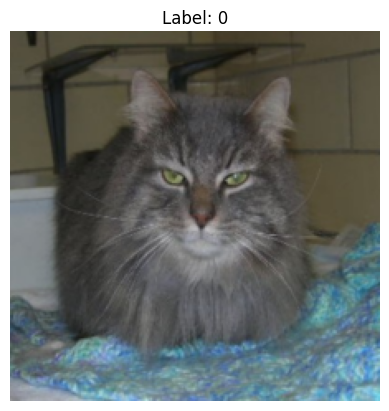

In [ ]:
from PIL import Image
import random
import matplotlib.pyplot as plt
from torchvision import transforms

# using a subset as test data to reduce processing time
subset_size = 1000

all_images = dataset["train"]["image"]
all_labels = dataset["train"]["labels"]

random_indices = random.sample(range(len(all_images)), subset_size)

test_images = [all_images[i] for i in random_indices]
test_labels = [all_labels[i] for i in random_indices]

# Convert grayscale images to RGB
def ensure_rgb_format(img):
    # Convert PIL Image to RGB mode if not already
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

# Define the preprocessing pipeline for the images
preprocess = transforms.Compose([
    transforms.Resize((224, 224))           # Resize the images to 224x224
])

# Apply the transformations to each image in the test dataset
test_images = [ensure_rgb_format(preprocess(img)) for img in test_images]


# Display an example image from the test dataset to verify preprocessing
plt.imshow(test_images[3], cmap='gray')
plt.title(f"Label: {test_labels[3]}")
plt.axis('off')  # to turn off the axis values
plt.show()

In this code segment, we decide to work with a subset of the loaded dataset, specifically selecting 1000 random samples. This decision reduces computational demand and speeds up subsequent operations. After obtaining the random subset, we ensure that all images are in RGB format. This is important as some models, including the one we're using, expect three channels (Red, Green, Blue) as input. Grayscale images, which have only one channel, are therefore converted to RGB to match this requirement. The images are also resized to 224 * 224 to match the model's input image dimensions. Finally, to verify that our preprocessing was successful and to get a visual sense of the data we're working with, we display a sample image from our test dataset, showcasing both the image and its corresponding label.

# 5. Running prediction on the test dataset

In [ ]:
import torch
import sys

BATCH_SIZE = 32

predictions = []

# Create batches
num_batches = len(test_images) // BATCH_SIZE + (1 if len(test_images) % BATCH_SIZE else 0)

for i in range(num_batches):
    batch_images = test_images[i*BATCH_SIZE: (i+1)*BATCH_SIZE]
    inputs = feature_extractor(batch_images, return_tensors="pt", padding=True)

    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_labels = logits.argmax(-1).tolist()
    predictions.extend(predicted_labels)

    # Print current batch number, overwriting the previous output
    sys.stdout.write(f'\rProcessing batch {i+1}/{num_batches}')
    sys.stdout.flush()

Processing batch 32/32

In this code segment, we set a batch size of 32 for efficient image processing. We determine the number of batches required and then loop through each batch. Images are preprocessed with the feature_extractor and forwarded through the model for predictions. Using torch.no_grad(), we ensure faster inference by avoiding gradient computations.

# 6. Convert predictions to binary values (0 for cat, 1 for dog)

In [ ]:
import requests
import ast

def closest_label(label, label_mapping):
    min_distance = float('inf')
    closest_key = None

    for test_label_key, matched_ids in label_mapping.items():
        for mapped_id in matched_ids:
            distance = abs(mapped_id - label)
            if distance < min_distance:
                min_distance = distance
                closest_key = test_label_key

    return closest_key


def map_predictions_to_binary(predicted_classes, test_labels_json):
    # Fetch the ImageNet label content from the URL
    imagenet_labels_url = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"
    response = requests.get(imagenet_labels_url)
    imagenet_labels = ast.literal_eval(response.text)

    # Identify ImageNet labels that correspond to each label in test_labels_json
    label_mapping = {}
    for test_label_key, test_label_value in test_labels_json.items():
        matched_ids = [key for key, value in imagenet_labels.items() if any(word.lower() == test_label_value.lower() for word in value.split())]
        label_mapping[test_label_key] = matched_ids

    # Print the label mappings
    for test_label, matched_ids in label_mapping.items():
      matched_labels = [imagenet_labels[id] for id in matched_ids]
      print(f"Test Label {test_labels_json[test_label]} maps to ImageNet Labels: {matched_labels}")

    # Convert predictions to binary format based on ImageNet and test dataset labels
    binary_predictions = []
    for label in predicted_classes:
        matched = False
        for test_label_key, matched_ids in label_mapping.items():
            if label in matched_ids:
                binary_predictions.append(test_label_key)
                matched = True
                break
        if not matched:
            binary_predictions.append(closest_label(label, label_mapping))

    return binary_predictions

# Convert predictions to binary values (0 for cat, 1 for dog)
test_labels_json = {0: 'cat', 1: 'dog'}
predicted_classes = map_predictions_to_binary(predictions, test_labels_json)

Test Label cat maps to ImageNet Labels: ['tabby, tabby cat', 'tiger cat', 'Persian cat', 'Egyptian cat', 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens']
Test Label dog maps to ImageNet Labels: ['Tibetan terrier, chrysanthemum dog', 'Greater Swiss Mountain dog', 'Bernese mountain dog', 'dalmatian, coach dog, carriage dog', 'affenpinscher, monkey pinscher, monkey dog', 'Newfoundland, Newfoundland dog', 'dogsled, dog sled, dog sleigh']


The code's objective is to transform ImageNet model predictions into binary classifications according to the user-defined test_labels_json. Initially, it extracts ImageNet's label mapping from a designated URL. The core logic begins by attempting to find exact matches between the user's test labels and the ImageNet labels. If a direct match is absent, the algorithm identifies the closest label by computing the minimal ID difference. The end result is a series of binary classifications, such as 0 for 'cat' and 1 for 'dog', based on the proximity of the prediction's ID to the matched IDs.

# 7. Visualizing prediction accuracy using a confusion matrix

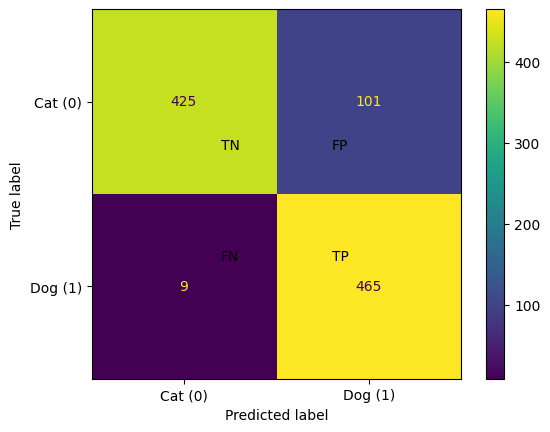


Accuracy: 0.89

              precision    recall  f1-score   support

     Cat (0)       0.98      0.81      0.89       526
     Dog (1)       0.82      0.98      0.89       474

    accuracy                           0.89      1000
   macro avg       0.90      0.89      0.89      1000
weighted avg       0.90      0.89      0.89      1000



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score

# Compute and display the confusion matrix
matrix = confusion_matrix(test_labels, predicted_classes)

ConfusionMatrixDisplay(matrix, display_labels=['Cat (0)', 'Dog (1)']).plot()

# Custom quadrant labels
# Offset values to place the labels in the top-left corner
offset_x = 0.2
offset_y = 0.2

# Add custom labels in the top-left corners
ax = plt.gca()
ax.text(0, 0, 'TN', va='top', ha='left', position=(0+offset_x, 0+offset_y))
ax.text(0, 1, 'FN', va='top', ha='left', position=(0+offset_x, 1-offset_y))
ax.text(1, 0, 'FP', va='top', ha='left', position=(1-offset_x, 0+offset_y))
ax.text(1, 1, 'TP', va='top', ha='left', position=(1-offset_x, 1-offset_y))

plt.show()

# Compute accuracy, classification report, and confusion matrix
accuracy = accuracy_score(test_labels, predicted_classes)
print(f"\nAccuracy: {accuracy:.2f}\n")
report = classification_report(test_labels, predicted_classes, target_names=['Cat (0)', 'Dog (1)'])
print(report)

**Observation**

The confusion matrix showcases the performance of a classification model on distinguishing between cats and dogs. Here are the observations:

*   The model has correctly identified 425 cats (True Negatives) and 465 dogs (True Positives).

*   In 101 instances, the model mistakenly predicted cats as dogs (False Positives).

*   On the other hand, the model wrongly classified 9 dogs as cats (False Negatives).

Overall, the model demonstrates a robust performance with a higher number of True Positives and True Negatives. However, there's a noticeable number of False Positives indicating areas for improvement. With some fine-tuning, especially in addressing the misclassifications, the performance can be further enhanced. As before, utilizing a pre-trained model has achieved this result. To improve, adapting the model specifically for a binary classification tailored for the *cats_vs_dogs* dataset or refining the pre-trained model with samples from this dataset might be beneficial.

# 8. Few examples to showcase sample predictions

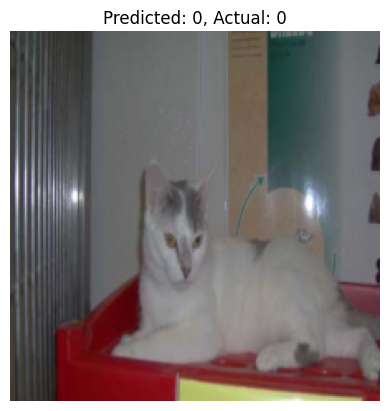

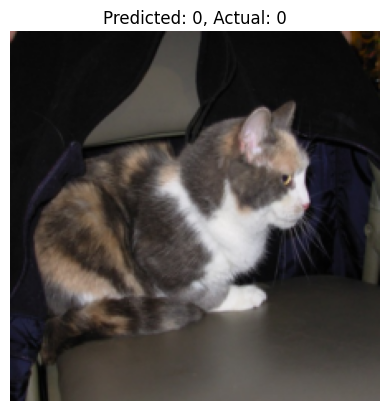

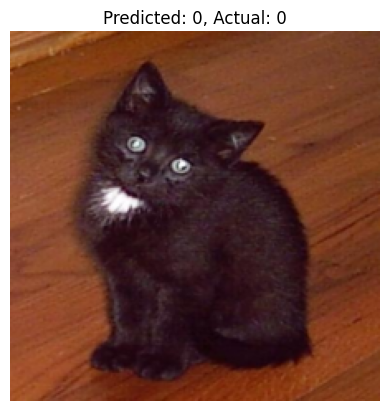

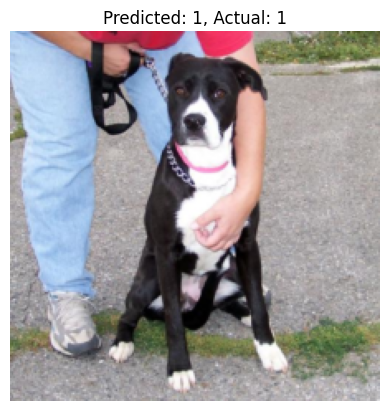

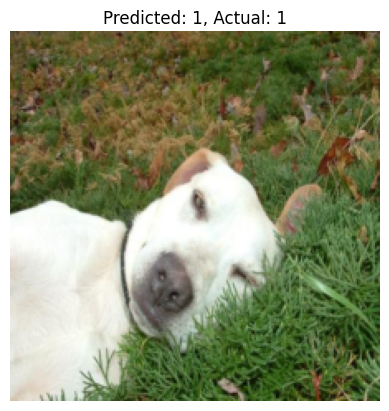

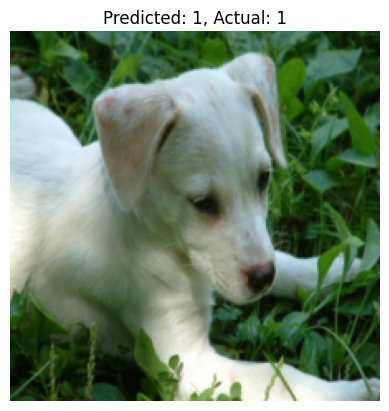

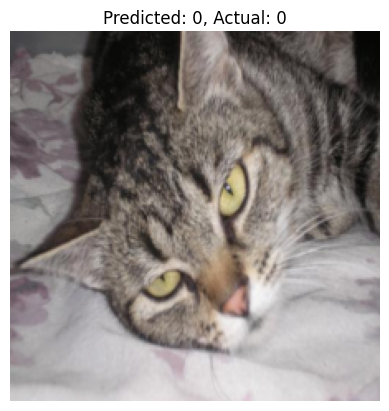

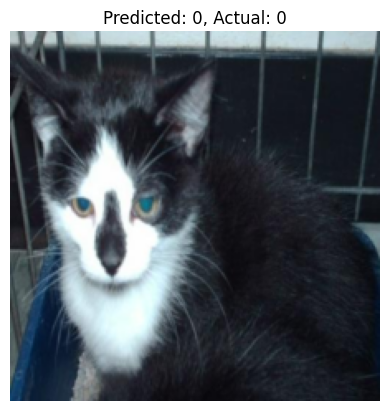

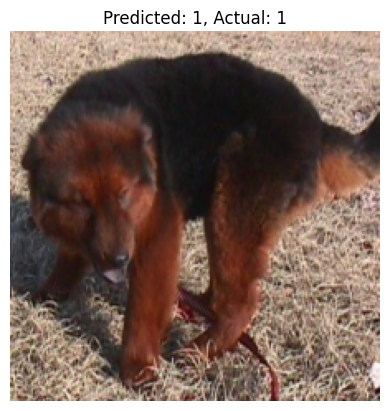

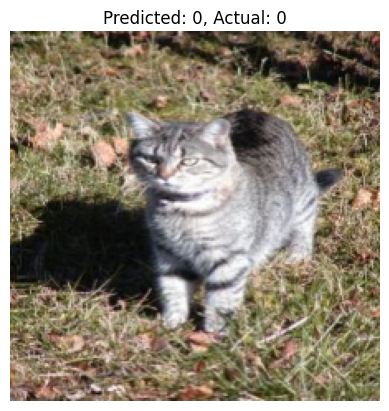

In [ ]:
# Select a few images to showcase sample predictions
sample_predicted_class_indices = [1, 100, 200, 300, 400, 500, 600, 700, 800, 900]

# Display sample images with actual vs. predicted labels
for i in sample_predicted_class_indices:
    print("\n")
    plt.imshow(test_images[i])
    plt.title(f"Predicted: {predicted_classes[i]}, Actual: {test_labels[i]}")
    plt.axis('off')
    plt.show()

**Observation**

The provided code snippet selectively showcases sample predictions from the model. Specifically, images at indices [1, 100, 200, 300, 400, 500, 600, 700, 800, 900] are chosen from the test dataset to visually inspect the model's predictions against the actual labels. Each displayed image is accompanied by its predicted and actual labels. From this selection, it's observed that all the chosen predictions align correctly with the actual labels, indicating a good performance of the model for these specific examples.